In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [67]:
# Load useful libraries
import numpy as np
import pandas as pd
import os
import tqdm
import pathlib
import time
import pickle
import seaborn as sns
import matplotlib.dates as mdates

# Plotting libraries
from matplotlib import pyplot as plt
%matplotlib inline

In [35]:
DATA_DIR="../datasets/"

MWRA_DATA_DIR=os.path.join(DATA_DIR, "mwra")
MWRA_DATA_FILE=os.path.join(MWRA_DATA_DIR, "data-20210424.csv")

MASS_COVID_DATA_DIR=os.path.join(DATA_DIR, "mass-covid")
MASS_COVID_DATA_FILE=os.path.join(MASS_COVID_DATA_DIR, "covid-19-raw-data-4-27-2021.xlsx")

In [63]:
# Load MWRA dataset
df_mwra = pd.read_csv(MWRA_DATA_FILE, parse_dates=['Date'])
display(df_mwra.tail(5))

,Date,Southern (copies/mL),Northern (copies/mL),Southern 7 day avg,Northern 7 day avg,Southern Low Confidence Interval,Southern High Confidence Interval,Northern Low Confidence Interval,Northern High Confidence Interval
414,2021-04-19,177,181.0,266.0,214,56,82,57,83
415,2021-04-20,198,131.0,257.0,207,62,91,41,61
416,2021-04-21,203,158.0,237.0,194,64,94,50,73
417,2021-04-22,355,108.0,239.0,174,112,164,34,50
418,2021-04-23,192,80.0,231.0,155,61,89,25,37


In [45]:
df_mwra.columns

Index(['Date', 'Southern (copies/mL)', 'Northern (copies/mL)',
       'Southern 7 day avg', 'Northern 7 day avg',
       'Southern Low Confidence Interval', 'Southern High Confidence Interval',
       'Northern Low Confidence Interval',
       'Northern High Confidence Interval'],
      dtype='object')

In [46]:
# Describe the dataset
df_mwra.describe()

,Southern (copies/mL),Northern (copies/mL),Southern 7 day avg,Northern 7 day avg,Southern Low Confidence Interval,Southern High Confidence Interval,Northern Low Confidence Interval,Northern High Confidence Interval
count,419.000000,417.000000,418.000000,419.000000,419.000000,419.000000,419.000000,419.000000
mean,273.649165,238.755396,271.846890,256.248210,86.486874,126.448687,75.109785,109.751790
std,395.912674,316.521194,318.712737,280.483717,125.104135,182.915802,99.923212,146.059945
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,21.000000,38.000000,47.500000,5.000000,7.500000,6.500000,9.500000
50%,97.000000,103.000000,134.000000,165.000000,31.000000,45.000000,32.000000,46.000000
75%,381.000000,318.000000,377.500000,336.000000,120.500000,176.500000,100.500000,146.500000
max,3772.000000,1451.000000,1476.000000,1130.000000,1192.000000,1743.000000,458.000000,670.000000


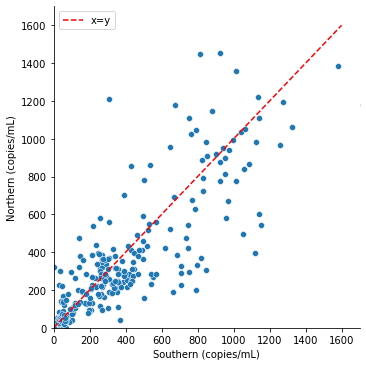

In [74]:
# Show the relation between norther and souther samples
sns.relplot(data=df_mwra, x="Southern (copies/mL)", y="Northern (copies/mL)")
plt.plot([0,1600], [0,1600], '--r', label="x=y")
plt.xlim([0, 1700])
plt.ylim([0, 1700])
plt.legend()

<ipython-input-70-a13590ec7191>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


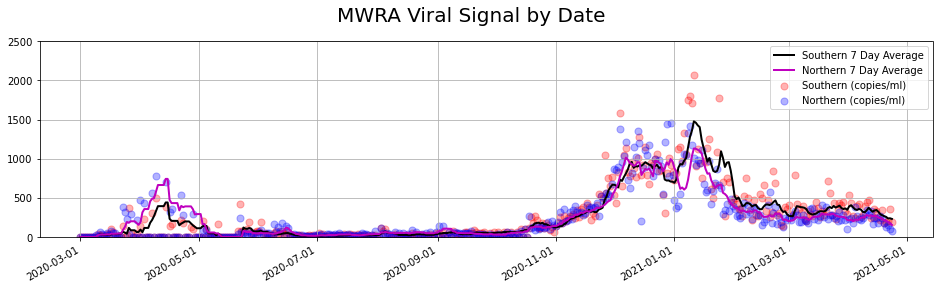

In [70]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.scatter(df_mwra['Date'], df_mwra['Southern (copies/mL)'], color='r', s = 50, alpha=0.3, label="Southern (copies/ml)")
ax.scatter(df_mwra['Date'], df_mwra['Northern (copies/mL)'], color='b', s = 50, alpha=0.3, label="Northern (copies/ml)")
ax.plot(df_mwra['Date'], df_mwra['Southern 7 day avg'], 'k', linewidth = 2,  label="Southern 7 Day Average")
ax.plot(df_mwra['Date'], df_mwra['Northern 7 day avg'], 'm', linewidth = 2, label="Northern 7 Day Average")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 2500])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

fig.autofmt_xdate()
fig.suptitle('MWRA Viral Signal by Date', fontsize=20, y=1.00)
fig.show()